In [1]:
import random
import pandas as pd
import numpy as np
import sklearn.ensemble
import os.path
import sklearn.neural_network
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import lime.lime_tabular_mod
import lime.lime_tabular_multiregressor
import lime.lime_tabular_multiclassifier
import lime.lime_tabular_singleclassifier
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
import doc.mod.utils.ResultsProcessing as rp
from tqdm import tqdm

repo = dr.DatasetRepository("../data")


pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})





# Dataset: Titanic

In [2]:
labels_count = 2
bins_count = 30
version_str = "v4"
dataset_name = "Titanic"
dataset = repo.get_titanic_dataset()
dataset.train_data

,Pclass,Sex,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,embarked_unknown,cabin_level_A,cabin_level_B,cabin_level_C,cabin_level_D,cabin_level_E,cabin_level_F,cabin_level_G,cabin_level_T,cabin_level_unknown
PassengerId,,,,,,,,,,,,,,,,,,,
601,2,0,24.000000,2,1,27.0000,0,0,1,0,0,0,0,0,0,0,0,0,1
690,1,0,15.000000,0,1,211.3375,0,0,1,0,0,1,0,0,0,0,0,0,0
434,3,1,17.000000,0,0,7.1250,0,0,1,0,0,0,0,0,0,0,0,0,1
673,2,1,70.000000,0,0,10.5000,0,0,1,0,0,0,0,0,0,0,0,0,1
733,2,1,29.699118,0,0,0.0000,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,3,1,29.699118,0,0,7.7500,0,1,0,0,0,0,0,0,0,0,0,0,1
371,1,1,25.000000,1,0,55.4417,1,0,0,0,0,0,0,0,1,0,0,0,0
68,3,1,19.000000,0,0,8.1583,0,0,1,0,0,0,0,0,0,0,0,0,1







## Train different classifiers on the selected dataset (with their default settings)

In [3]:
models = [
    ("las losowy", sklearn.ensemble.RandomForestClassifier(n_jobs=-1)),
    ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
    ("drzewo decyzyjne", sklearn.tree.DecisionTreeClassifier()),
    ("sieć neuronowa", sklearn.neural_network.MLPClassifier()),
    # ("SVM", sklearn.svm.LinearSVC()), do not provide predict_proba
    ("naiwny k. bayesowski", sklearn.naive_bayes.GaussianNB()),
    ("kNN", sklearn.neighbors.KNeighborsClassifier())
]
precision_for_classifier = {}
recall_for_classifier = {}
f1_for_classifier = {}
for (classifier_name, model) in models:
    x = dataset.train_data.to_numpy()
    y = dataset.train_labels.to_numpy()
    model.fit(x, y)

    x = dataset.test_data.to_numpy()
    y_true = dataset.test_labels.to_numpy()
    y_predicted = model.predict(x)

    precision_for_classifier[classifier_name] = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_predicted, average="macro")
    recall_for_classifier[classifier_name] = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_predicted, average="macro")
    f1_for_classifier[classifier_name] = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_predicted, average="macro")

test_data_subset = dataset.test_data.to_numpy()

test_instances_count = test_data_subset.shape[0]

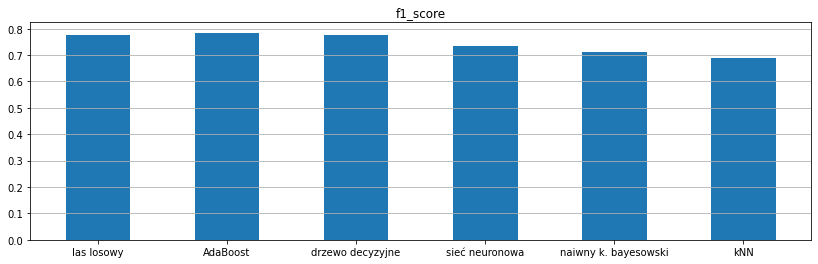

In [4]:
plt.figure(figsize=(14,4))
plt.bar(f1_for_classifier.keys(), f1_for_classifier.values(), width=0.5)
plt.title("f1_score")
plt.grid(axis="y")
plt.show()





### Use multiple Regression Trees as local surrogate

In [5]:
explanation_for_classifier = {}
test_instance = random.choice(test_data_subset)

for classifier_name, model in models:
    explainer_multiregression = lime.lime_tabular_multiregressor.LTEMultiRegressionTree(
        dataset.train_data.to_numpy(),
        feature_names = dataset.train_data.columns.to_list(),
        class_names = model.classes_,
        discretize_continuous=False,
        sample_around_instance=True,
        use_inversed_data_for_training=True,
        categorical_features=dataset.categorical_features,
    )
    explanation_for_classifier[classifier_name] = explainer_multiregression.explain_instance(
        test_instance.reshape(-1),
        model.predict_proba,
        num_features = 4,
        top_labels = labels_count,
        distance_metric="minkowski",
        minkowski_norm=2.
    )

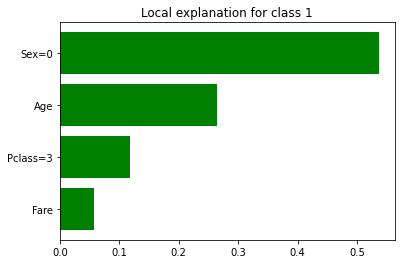

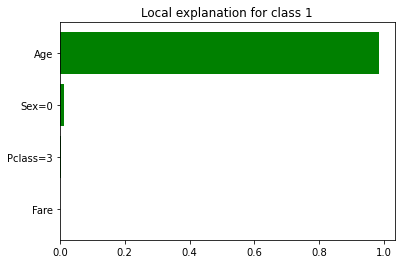

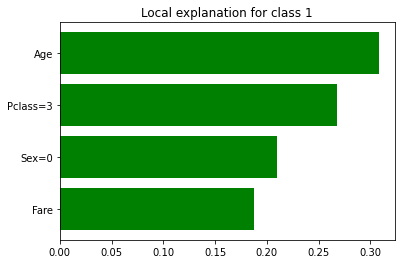

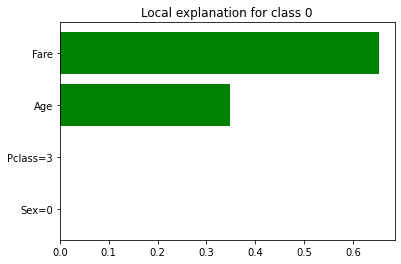

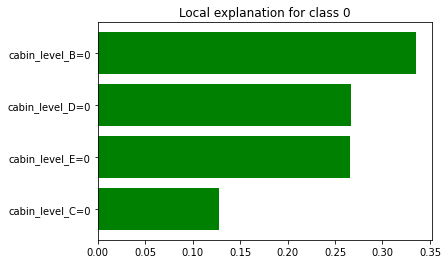

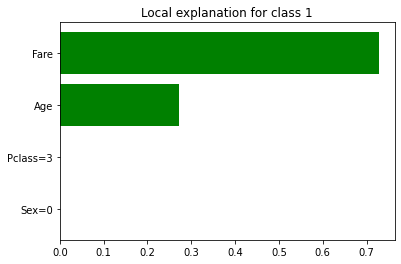

In [6]:
file_prefix = f"../data/img/tree_explanation/{dataset_name}"
for classifier_name,_ in models:
    explanation_for_classifier[classifier_name].render_explanation_tree(
        file_to_render=f"{file_prefix}/tree_explanation_{classifier_name.replace(' ', '')}.png"
    )
    explanation_for_classifier[classifier_name].as_pyplot_figure(
        explanation_for_classifier[classifier_name].top_labels[0]).savefig(
            f"{file_prefix}/old_explanation_{classifier_name.replace(' ', '')}.png",
            bbox_inches="tight",
            pad_inches=0.1
    )

In [7]:
pd.Series(
    test_instance,
    index=dataset.train_data.columns)


Pclass                  3.00
Sex                     0.00
Age                    16.00
SibSp                   0.00
Parch                   0.00
Fare                    7.75
embarked_C              0.00
embarked_Q              1.00
embarked_S              0.00
embarked_unknown        0.00
cabin_level_A           0.00
cabin_level_B           0.00
cabin_level_C           0.00
cabin_level_D           0.00
cabin_level_E           0.00
cabin_level_F           0.00
cabin_level_G           0.00
cabin_level_T           0.00
cabin_level_unknown     1.00
dtype: float64

In [11]:
print(explanation_for_classifier["las losowy"].get_decision_rules_for_explanation())


Sklasyfikowano jako '1', ponieważ:
		cecha Sex (o wartości 0.0) była <= 0.5
	oraz	cecha Pclass (o wartości 3.0) była > 2.5
	oraz	cecha Age (o wartości 16.0) była <= 26.35
	oraz	cecha Age (o wartości 16.0) była > 7.491

